# Ant_DF1981-2010 (30 days aríthmetic mean)

In [1]:
import warnings
warnings.simplefilter("ignore")
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
#
import matplotlib
import matplotlib.pyplot as plt
#
import cartopy.crs as ccrs

In [2]:
def cmd(cmd):
    # Pythonでシェルコマンドを動かし、結果を取得する関数
    # 参考 : https://qiita.com/inatatsu_csg/items/40b11701d256a84a0510 
    import subprocess
    process = (subprocess.Popen(cmd, stdout=subprocess.PIPE, shell=True).communicate()[0]).decode('utf-8')[:-1]
    return process

In [3]:
# 描画設定
plt.rcParams['figure.dpi'] = 300
plt.rcParams.update({'font.family': 'sans-serif', 'text.usetex': False,'pcolor.shading':'auto'})

In [4]:
class Site:
    def DomeF(self):
        sx=14 ; sy=60 # 77°18′59″S 39°42′04″E
        df_lat=-77.3
        df_lon=39.66
        return df_lon,df_lat,sx,sy

In [5]:
df_lon,df_lat,df_x,df_y = Site().DomeF()    

In [6]:
def Mon():
    import pandas as pd
    mons = pd.DataFrame({
            "name"     : ["Jan", "Feb", "Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec","Jan"], 
            "days"     : [31,28,31,30,31,30,31,31,30,31,30,31,31], 
            "dayacc"   : [0,31,59,90,120,151,181,212,243,273,304,334,365], 
            "days_lp"  : [31,29,31,30,31,30,31,31,30,31,30,31,31], 
            "dayacc_lp": [0,31,60,91,121,152,182,213,244,274,305,335,366]             
            })
    return mons
mons=Mon()

In [7]:
monlist=[]
yrlist=[]
yy=[]
for yr in range(12):
    yy      = np.append(yy,1980)
    
for yr in range(30):
    monlist = np.append(monlist,np.arange(1,13,1))
    yy      = yy+1
    yrlist  = np.append(yrlist,yy)

In [8]:
loadfile  = "prcp_d18O_anom.npz"
dataset   = np.load(loadfile)
prcp_d18O = dataset["prcp_d18O"][df_x-1,df_y-1,:]
y        = dataset["y"]
m        = dataset["m"]
d        = dataset["d"]

In [9]:
loadfile = "sammon.npz"
dataset  = np.load(loadfile)
sammon   = dataset["sam"]

In [10]:
loadfile = "sam.npz"
dataset  = np.load(loadfile)
sam   = dataset["sam"]

In [11]:
def corr(a1,a2):
    sa1  = a1[~(np.isnan(a1)+np.isnan(a2))]
    sa2  = a2[~(np.isnan(a1)+np.isnan(a2))]
    
    san1 = (sa1-np.nanmean(sa1))/np.nanstd(sa1)
    san2 = (sa2-np.nanmean(sa2))/np.nanstd(sa2)
    
    r, p = stats.spearmanr(san1,san2)
    
    if r<0:
        rmse = np.sqrt(mean_squared_error(san1*-1,san2))
    else:
        rmse = np.sqrt(mean_squared_error(san1   ,san2))
                         
    return r, p, rmse

In [12]:
def hor_lines(ax, yint):
    if len(yint) < 2 :
        ax.axhline(y=yint,ls='-',linewidth=1, color='k')
    else:
        for i in range(len(yint)):
            ax.axhline(y=yint[i],ls='--',linewidth=1, color='k')  
            
    return ax

In [13]:
col_model="red"
col_obs="black"

In [14]:
def moving_average(x, num):
    time = len(x)
    xout = np.zeros(time)
    
    for ii in np.arange(int(num/2),int((time-num/2)),1):
        xout[ii] = np.nanmean(x[ii:ii+num])
    xout[:int(num/2)] = np.nan
    xout[int(time-int(num/2)-1):] = np.nan
    return xout

In [15]:
# 移動平均
num = 30

sam_ann                                 = moving_average(sam      , num)
d18O_ann                              = moving_average(prcp_d18O   , num)

In [16]:
r, p, rmse=corr(d18O_ann,sam_ann)

print("Spearman's correlation coefficient={:4.2f},".format(r), "p={:}".format(p))
title="$r={:4.2f}$".format(r)+" ($p={:}$)".format(p)+", RMSE={:4.2f}".format(rmse)
print("RMSE={:4.2f}".format(rmse))

Spearman's correlation coefficient=-0.52, p=0.0
RMSE=0.94


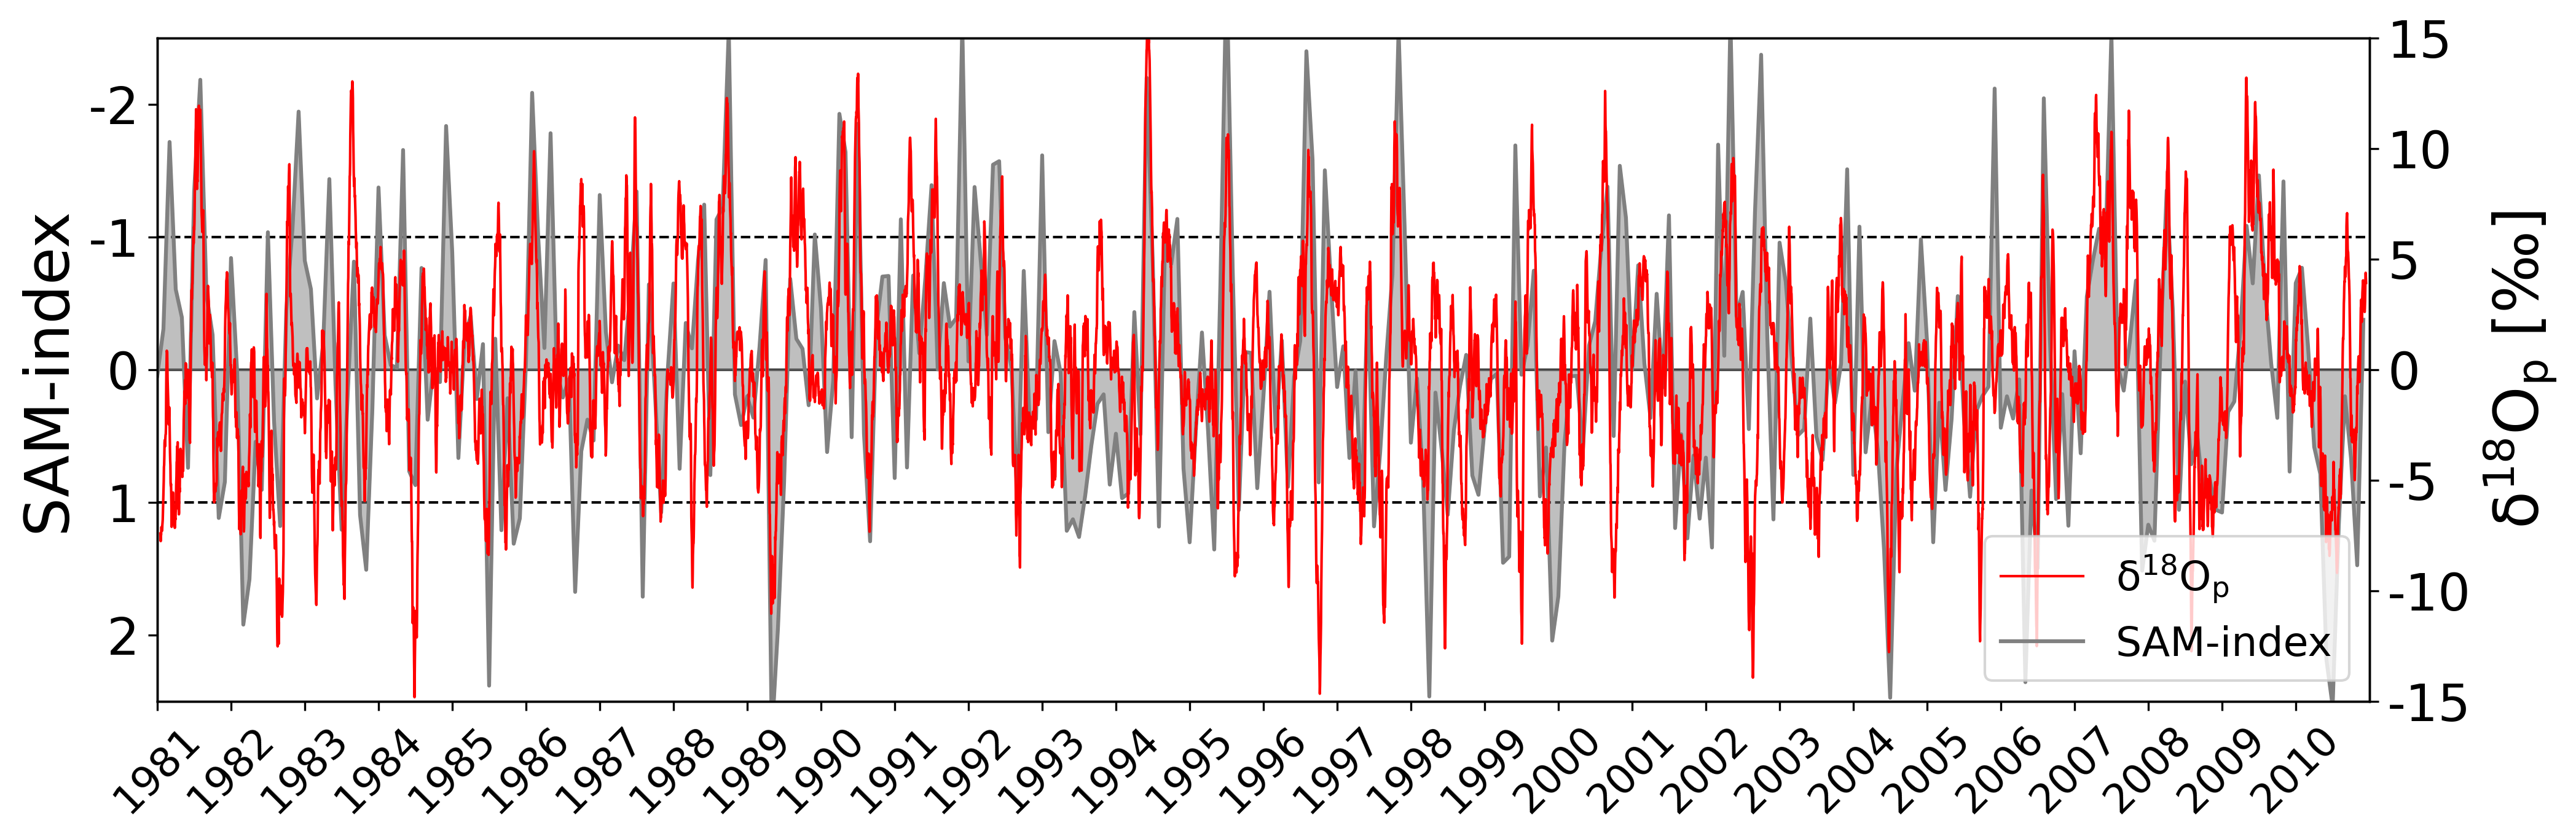

In [17]:
time=range(len(sam))
fig = plt.figure(figsize=(15,5)) 

ax2 = fig.add_subplot(1,1,1)
#ax2.set_title(title)

ax2.tick_params    (labelsize=24)
ax2.set_ylabel     ("SAM-index", fontsize=24, color=col_obs) 
ax2.set_xlim       (0,len(sam))
ax2.set_ylim       (2.5,-2.5)
ax2.set_xticks([])
ax2.set_yticks     ([2,1,0,-1,-2])
ax2.set_yticklabels([2,1,0,-1,-2],fontsize=20)
hor_lines(ax2, [0])
hor_lines(ax2, [-1,1])
ax3=ax2.twiny()
ax3.fill_between(range(len(sammon)), sammon , color="gray", alpha=0.5)
                 #                 label="SAM-index (monthly defined)")
ax3.plot(range(len(sammon)), sammon , color="gray", label="SAM-index")
ax3.set_xlim(0,len(sammon))
ax3.set_xticks     (np.arange(0,len(sammon),12))
ax3.set_xticklabels(np.arange(1981,2011,1),rotation=45,fontsize=16)
ax3.xaxis.tick_bottom()

ax=ax2.twinx()
ax.plot(time,(d18O_ann-np.nanmean(d18O_ann)), ms=10, color=col_model, linewidth=1,
        label="$\mathrm{\delta^{18}O_{p}}$")
        #        label="$\mathrm{\delta^{18}O_{p}}$ (moving average for 30 days)")

ax.tick_params    (               labelsize=24)
ax.set_ylabel     ("$\mathrm{\delta^{18}O_{p}}$ [\u2030]", fontsize=24, color="black") 
ax.set_xlim       (0,len(sam))
ax.set_ylim       (-15,15)
ax.set_yticks     ([-15,-10,-5,0,5,10,15])
ax.set_yticklabels([-15,-10,-5,0,5,10,15],fontsize=16)
ax.tick_params    (               labelsize=20)#


h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
h3, l3 = ax3.get_legend_handles_labels()
plt.legend(h1+h2+h3, l1+l2+l3, loc='best',fontsize=16)

plt.subplots_adjust(top=0.92, bottom=0.2, left=0.1, right=0.9, hspace=0.2, wspace=0.05)
plt.show()
fig.savefig("Ant_DF1981-2010.png")
fig.savefig("pic/Figure6.jpg")

Kanon Kino (kanon[at]aori.u-tokyo.ac.jp)